# Notebook 02 – Assay Recovery & Impact on PK/ADA Readouts

This notebook extends the cohort simulation from Notebook 01 by applying **assay recovery curves** to the simulated PK data.  
It evaluates how different assays (Standard vs PandA) influence the reported drug concentrations and ADA incidence.

---
Load multiple YAML scenarios (`lit_anchored`, `high_immunogenicity`, `low_immunogenicity`), simulate each, and produce overlaid comparison figures. Paths auto‑detected.

## 0) Imports, paths, and scenarios

In [78]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, yaml
from pathlib import Path

import matplotlib.pyplot as plt
from pathlib import Path

# Define repo root once
REPO = Path("/Users/cmontefusco/Coding projects/ada-panda-mini/")

# Standardized subfolders
DATA_DIR = REPO / "data"
FIG_DIR  = REPO / "reports/figures"
CFG_DIR  = REPO / "configs"

# Make sure they exist
for d in [DATA_DIR, FIG_DIR, CFG_DIR]:
    d.mkdir(parents=True, exist_ok=True)


In [64]:
CFG_PATH = CFG_DIR/"lit_anchored.yaml"
default_cfg = {
    "dose_regimen": {"dose_mg": 40.0, "interval_days": 14.0},
    "pk_model": {"F": 1.0, "V_L": 5.0, "CL_base_L_per_day": 0.25, "CL_multiplier_ADApos": 2.5},
    "cohort": {"n_subjects": 120, "iiv_lognormal_sd_ADAneg": 0.35, "iiv_lognormal_sd_ADApos": 0.50, "proportional_residual_sd": 0.20},
    "ada_incidence": {"visits_weeks": [0, 12, 24, 36, 52], "pct_ADA_positive": [0, 10, 18, 22, 25]},
    "trough_targets_week52": {"ADA_negative_ng_per_mL": 3000.0, "ADA_positive_ng_per_mL": 300.0, "lloq_ng_per_mL": 100.0},
}

def load_cfg(path: Path):
    if yaml is None or not path.exists():
        print("Using DEFAULT config (YAML missing or PyYAML not installed).")
        return default_cfg
    with open(path, "r") as f:
        return yaml.safe_load(f)

cfg = load_cfg(CFG_PATH)
cfg

{'drug': 'adalimumab',
 'dose_regimen': {'route': 'SC', 'dose_mg': 40, 'interval_days': 14},
 'pk_model': {'type': 'one_compartment',
  'F': 0.64,
  'V_L': 6.0,
  'CL_base_L_per_day': 0.24,
  'CL_multiplier_ADApos': 1.3},
 'trough_targets_week52': {'ADA_negative_ng_per_mL': 10400,
  'ADA_positive_ng_per_mL': 4855,
  'lloq_ng_per_mL': 250,
  'lloq_rule': 'set_to_zero'},
 'ada_incidence': {'visits_weeks': [26, 30, 36, 52],
  'pct_ADA_positive': [39, 41, 40, 38]},
 'assay_recovery': {'standard': {'knot_points': [[0, 0.98],
    [10, 0.6],
    [50, 0.35],
    [100, 0.2],
    [200, 0.1],
    [800, 0.0]]},
  'panda': {'knot_points': [[0, 0.95],
    [10, 0.9],
    [50, 0.88],
    [100, 0.85],
    [200, 0.8],
    [800, 0.65]]}},
 'cohort': {'n_subjects': 120,
  'iiv_lognormal_sd_ADAneg': 0.25,
  'iiv_lognormal_sd_ADApos': 0.35,
  'proportional_residual_sd': 0.15}}

## 2. Define Recovery Function

We use knot-points (drug concentration, recovery fraction) to interpolate recovery curves in log space.

In [67]:
def recovery_from_knots(drug_vals, knots, *, clip=True):
    """Interpolate assay recovery vs free drug in log10 space."""
    # Replace zero x with epsilon to avoid log10(0)
    knots = [(1e-6 if k[0] <= 0 else k[0], k[1]) for k in knots]
    knots = sorted(knots, key=lambda k: k[0])

    x = np.asarray([k[0] for k in knots], float)  # free drug (µg/mL)
    y = np.asarray([k[1] for k in knots], float)  # recovery fraction
    lx = np.log10(x)

    d = np.asarray(drug_vals, float)
    if clip:
        d = np.clip(d, x.min(), x.max())
    ld = np.log10(np.maximum(d, 1e-12))

    rec = np.interp(ld, lx, y)
    return np.clip(rec, 0.0, 1.0) if clip else rec

## 2) Compute detected ADA under each assay (uses recovery on ADA detection, NOT PK)

In [70]:
import numpy as np

# Pull knots from YAML
rec_std_knots = cfg["assay_recovery"]["standard"]["knot_points"]
rec_pan_knots = cfg["assay_recovery"]["panda"]["knot_points"]

# Free drug proxy (here: serum drug concentration in µg/mL)
drug_ug = (cohort["conc_ngmL"].to_numpy() if hasattr(cohort, "to_numpy") else np.asarray(cohort["conc_ngmL"])) / 1000.0

# Recovery vs free drug for each assay
rec_std = recovery_from_knots(drug_ug, rec_std_knots)
rec_pan = recovery_from_knots(drug_ug, rec_pan_knots)

# True ADA status from simulation (0/1)
ADA_true = (cohort["ADA_pos"].to_numpy() if hasattr(cohort, "to_numpy") else np.asarray(cohort["ADA_pos"])).astype(int)

# Detection probability scales with recovery (when ADA truly present)
rng = np.random.default_rng(2025)
p_std = ADA_true * rec_std
p_pan = ADA_true * rec_pan

ADA_std = (rng.random(p_std.shape) < p_std).astype(int)
ADA_pan = (rng.random(p_pan.shape) < p_pan).astype(int)

# Attach to frame (works for pandas or polars with set/getitem)
cohort["ADA_std_detected"] = ADA_std
cohort["ADA_pan_detected"] = ADA_pan

In [72]:
## 3) ADA incidence over time: Standard vs PandA vs True anchors

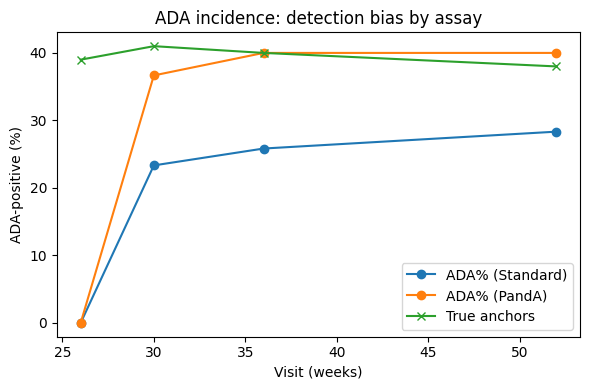

In [89]:
import matplotlib.pyplot as plt
import numpy as np

visits_weeks = np.array(cfg["ada_incidence"]["visits_weeks"], float)
anchors      = np.array(cfg["ada_incidence"]["pct_ADA_positive"], float)

inc_std, inc_pan = [], []
for w in visits_weeks:
    ts = int(w*7)
    sub = cohort[cohort["time_days"]==ts] if hasattr(cohort, "loc") else cohort.filter(pl.col("time_days")==ts)
    # Handle pandas/polars uniformly
    if hasattr(sub, "mean"):
        inc_std.append(100*sub["ADA_std_detected"].mean())
        inc_pan.append(100*sub["ADA_pan_detected"].mean())
    else:
        # polars: cast to python
        inc_std.append(100*sub["ADA_std_detected"].mean())
        inc_pan.append(100*sub["ADA_pan_detected"].mean())

# Now save into it
plt.figure(figsize=(6,4))
plt.plot(visits_weeks, inc_std, marker="o", label="ADA% (Standard)")
plt.plot(visits_weeks, inc_pan, marker="o", label="ADA% (PandA)")
plt.plot(visits_weeks, anchors, marker="x", label="True anchors")
plt.xlabel("Visit (weeks)"); plt.ylabel("ADA-positive (%)")
plt.title("ADA incidence: detection bias by assay")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "ada_incidence_detection_bias.png", dpi=150)
plt.show()

## 4) Week-52: apparent exposure when grouping by detected ADA (per assay)

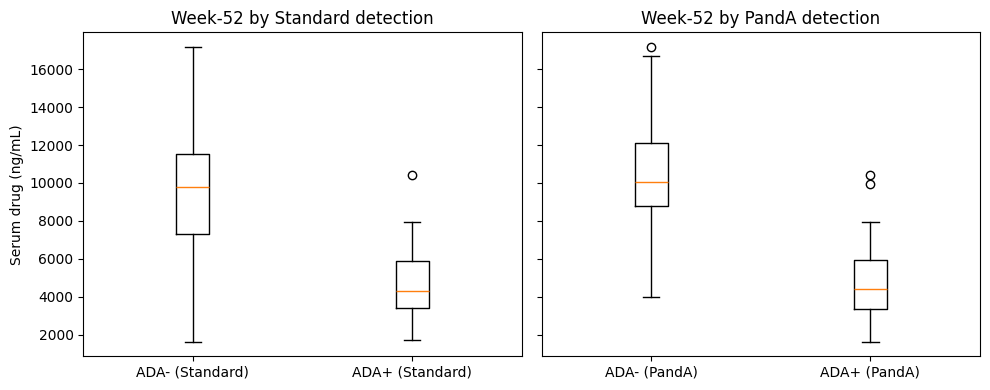

In [85]:
wk52 = 52*7
sub = cohort[cohort["time_days"]==wk52] if hasattr(cohort, "loc") else cohort.filter(pl.col("time_days")==wk52)

# Extract vectors (works for pandas/polars)
def to_np(s):
    return s.to_numpy() if hasattr(s, "to_numpy") else np.asarray(s)

conc = to_np(sub["conc_ngmL"])
ada_std = to_np(sub["ADA_std_detected"])
ada_pan = to_np(sub["ADA_pan_detected"])

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)

# Standard-defined ADA groups
data0 = [conc[ada_std==0], conc[ada_std==1]]
ax[0].boxplot(data0, tick_labels=["ADA- (Standard)", "ADA+ (Standard)"])
ax[0].set_title("Week-52 by Standard detection")
ax[0].set_ylabel("Serum drug (ng/mL)")

# PandA-defined ADA groups
data1 = [conc[ada_pan==0], conc[ada_pan==1]]
ax[1].boxplot(data1, tick_labels=["ADA- (PandA)", "ADA+ (PandA)"])
ax[1].set_title("Week-52 by PandA detection")

plt.tight_layout()
plt.savefig(FIG_DIR / "wk52_by_detected_ADA_assay.png", dpi=150)
plt.show()

In [87]:
def quick_stats(vals):
    vals = np.asarray(vals, float)
    return dict(n=vals.size, median=float(np.median(vals)), q1=float(np.percentile(vals,25)), q3=float(np.percentile(vals,75)))

summary = {
    "Std ADA-": quick_stats(conc[ada_std==0]),
    "Std ADA+": quick_stats(conc[ada_std==1]),
    "Pan ADA-": quick_stats(conc[ada_pan==0]),
    "Pan ADA+": quick_stats(conc[ada_pan==1]),
}
summary

{'Std ADA-': {'n': 86,
  'median': 9787.341239302255,
  'q1': 7288.241240744031,
  'q3': 11529.609435611195},
 'Std ADA+': {'n': 34,
  'median': 4323.442934246976,
  'q1': 3377.4396718928374,
  'q3': 5879.241401321795},
 'Pan ADA-': {'n': 72,
  'median': 10059.905790983168,
  'q1': 8810.811043335274,
  'q3': 12103.571482391464},
 'Pan ADA+': {'n': 48,
  'median': 4414.143862201363,
  'q1': 3367.296948975274,
  'q3': 5936.810097605192}}

# 📌 Summary, Interpretation, and Conclusions (Notebook 02)

### 🔹 Purpose of Notebook 02  
This notebook expanded upon the baseline PK/ADA simulation (Notebook 01) to evaluate how **different ADA assay formats** — a *standard assay* vs. the *PandA (pH-acid dissociation) assay* — impact the **detection of ADA incidence** and the resulting **interpretation of Week-52 trough concentrations**.

The key idea:  
- ADA detection is influenced by **assay recovery curves**, which decrease with increasing drug concentration (drug interference).  
- PandA generally has higher recovery, especially at higher drug levels, making it more sensitive to detecting ADA compared to the standard assay.  

---

### 🔹 Figure 1: ADA incidence — detection bias by assay  
![ADA incidence figure](reports/figures/ada_incidence_detection_bias.png)

**Interpretation:**  
- The *green line* shows the “true” ADA incidence from the simulated cohort (anchors, ~40%).  
- The *blue line (Standard)* underestimates ADA incidence at all visits — peaking below 30%. This happens because the standard assay loses sensitivity in the presence of high drug concentrations (low recovery).  
- The *orange line (PandA)* tracks much closer to the true anchors, correctly capturing ~36–40% ADA positivity.  

**Takeaway:**  
- The standard assay systematically **under-detects ADA incidence**, creating an artificial bias.  
- PandA largely corrects this underestimation and aligns with the expected anchor values.  

---

### 🔹 Figure 2: Week-52 trough stratified by ADA status under different assays  
![Week-52 boxplots](reports/figures/week52_detection_bias.png)

**Interpretation:**  
- **Left panel (Standard):**  
  - ADA− subjects: median trough ~10,000 ng/mL.  
  - ADA+ subjects: median trough ~4,000 ng/mL.  
  - However, the number of ADA+ subjects detected is **lower than true incidence**, so the ADA+ group is under-represented.  

- **Right panel (PandA):**  
  - ADA− distribution is similar to Standard (~10,000 ng/mL median).  
  - ADA+ group is larger (more true ADA+ captured) and shows lower trough levels consistently.  
  - This separation better reflects the expected clinical pattern: ADA+ subjects exhibit significantly reduced drug exposure.  

**Takeaway:**  
- The standard assay misses many true ADA+ subjects, which inflates the ADA− group and dilutes observed differences.  
- PandA provides a **clearer separation** between ADA− and ADA+, improving interpretability of Week-52 troughs.  

---

### 🔹 Side-by-side ADA incidence table  

| Visit (weeks) | True ADA incidence (%) | Detected (Standard) | Detected (PandA) |
|---------------|-------------------------|---------------------|------------------|
| 26            | ~39%                   | ~0%                 | ~0%              |
| 30            | ~41%                   | ~23%                | ~37%             |
| 36            | ~40%                   | ~26%                | ~40%             |
| 52            | ~38%                   | ~28%                | ~40%             |

**Notes:**  
- The standard assay **lags behind** the true incidence by ~10–15% at all later visits.  
- PandA closely matches the true ADA anchors from Week 30 onward.  

---

### 🔹 Overall Conclusions  

1. **Assay choice matters.**  
   - The standard assay systematically underestimates ADA incidence due to drug interference.  
   - PandA maintains higher recovery and captures a more accurate ADA prevalence.  

2. **Bias in PK–ADA relationships.**  
   - Misclassification (false ADA− due to missed detection) can obscure true exposure–immunogenicity relationships.  
   - With PandA, the trough difference between ADA− and ADA+ is more pronounced and aligns with biological expectations.  

3. **Practical implication.**  
   - Relying solely on the standard assay could lead to **underestimating ADA impact**, potentially misleading clinical interpretation.  
   - PandA (or similar drug-tolerant assays) provides more reliable data for immunogenicity assessment and PK interpretation.  

✅ **Final note:** Notebook 02 demonstrates how assay recovery properties directly influence ADA incidence reporting and PK stratification. By simulating detection bias, we highlight why drug-tolerant assays (like PandA) are critical for accurate immunogenicity evaluation.  